<a href="https://colab.research.google.com/github/hamagami/preprocess/blob/main/06_01_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ほぼカテゴリカルデータの場合の回帰分析

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## 学習につかうモジュール
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#いろいろな回帰分析のモデル
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
#%matplotlib inline

kaggleのデータ pizzaを取得

In [26]:
df= pd.read_csv("https://dl.dropbox.com/s/ttng1f37eesou74/pizza_v1.csv")

データの中身を確認

In [27]:
df

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,"Rp235,000",22.0,chicken,double_signature,jumbo,yes,yes
1,A,"Rp198,000",20.0,papperoni,double_signature,jumbo,yes,yes
2,A,"Rp120,000",16.0,mushrooms,double_signature,reguler,yes,yes
3,A,"Rp155,000",14.0,smoked beef,double_signature,reguler,yes,no
4,A,"Rp248,000",18.0,mozzarella,double_signature,jumbo,yes,no
...,...,...,...,...,...,...,...,...
124,E,"Rp39,000",8.5,tuna,spicy tuna,small,yes,yes
125,E,"Rp72,000",12.0,tuna,spicy tuna,medium,yes,yes
126,E,"Rp99,000",14.0,tuna,spicy tuna,large,yes,yes
127,E,"Rp44,000",8.5,meat,BBQ_meat_fiesta,small,yes,no


In [28]:
df.info()#欠損値のチェック

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       129 non-null    object 
 1   price_rupiah  129 non-null    object 
 2   diameter      129 non-null    float64
 3   topping       129 non-null    object 
 4   variant       129 non-null    object 
 5   size          129 non-null    object 
 6   extra_sauce   129 non-null    object 
 7   extra_cheese  129 non-null    object 
dtypes: float64(1), object(7)
memory usage: 8.2+ KB


In [29]:
df.describe()# 数値データ（この例では　diameterしかない）のチェック

,diameter
count,129.000000
mean,12.976744
std,3.272674
min,8.000000
25%,12.000000
50%,12.000000
75%,14.000000
max,22.000000


ルピアの表記をとって数値型にして、わかりやすいように円にする　１ルピア＝0.0075とします

In [30]:
df['price_yen'] = df['price_rupiah'].str.replace('\D+','',regex=True)
df['price_yen'] = pd.to_numeric(df['price_yen'])*0.0075
df=df.drop('price_rupiah',axis=1)
df['price_yen'].dtype

dtype('float64')

In [31]:
df

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,price_yen
0,A,22.0,chicken,double_signature,jumbo,yes,yes,1762.5
1,A,20.0,papperoni,double_signature,jumbo,yes,yes,1485.0
2,A,16.0,mushrooms,double_signature,reguler,yes,yes,900.0
3,A,14.0,smoked beef,double_signature,reguler,yes,no,1162.5
4,A,18.0,mozzarella,double_signature,jumbo,yes,no,1860.0
...,...,...,...,...,...,...,...,...
124,E,8.5,tuna,spicy tuna,small,yes,yes,292.5
125,E,12.0,tuna,spicy tuna,medium,yes,yes,540.0
126,E,14.0,tuna,spicy tuna,large,yes,yes,742.5
127,E,8.5,meat,BBQ_meat_fiesta,small,yes,no,330.0


価格の部分をヒストグラム

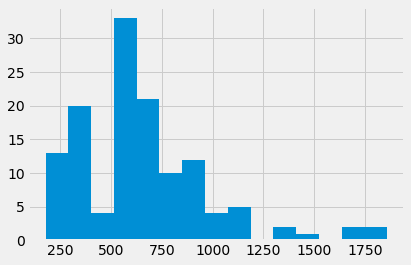

In [32]:
plt.hist(df['price_yen'],bins=15)
plt.show()

直径の分布もみておく

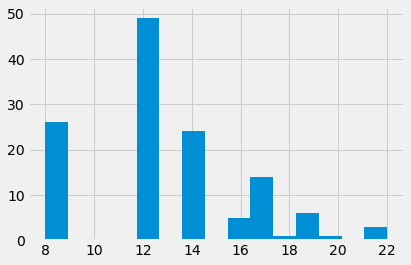

In [33]:
plt.hist(df['diameter'],bins=15)
plt.show()

カテゴリカルデータだけを取り出してエンコードする

In [34]:
cols_to_encode = df.drop(['diameter','price_yen'],axis=1).columns #数値データを外す
cols_to_encode

Index(['company', 'topping', 'variant', 'size', 'extra_sauce', 'extra_cheese'], dtype='object')

単純なone-hotエンコーディング
drop_first は　すべて０の場合も１つのラベルに割り当てる設定 k個の属性に対して k-1次元の属性で表現する

In [35]:
dummies = pd.get_dummies(df[cols_to_encode],drop_first=True)
dummies.shape

(129, 41)

In [36]:
dummies.head() #すべてカテゴリカルなデータになった(41次元にもなる）)

,company_B,company_C,company_D,company_E,topping_black papper,topping_chicken,topping_meat,topping_mozzarella,topping_mushrooms,topping_onion,topping_papperoni,topping_sausage,topping_smoked beef,topping_tuna,topping_vegetables,variant_BBQ_sausage,variant_american_classic,variant_american_favorite,variant_classic,variant_crunchy,variant_double_decker,variant_double_mix,variant_double_signature,variant_extravaganza,variant_gournet_greek,variant_italian_veggie,variant_meat_eater,variant_meat_lovers,variant_neptune_tuna,variant_new_york,variant_spicy tuna,variant_spicy_tuna,variant_super_supreme,variant_thai_veggie,size_jumbo,size_large,size_medium,size_reguler,size_small,extra_sauce_yes,extra_cheese_yes
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


数値データだけを取り出す

In [37]:
df.drop(cols_to_encode,axis=1,inplace=True) #カテゴリカルなデータをはずす
df.head()

,diameter,price_yen
0,22.0,1762.5
1,20.0,1485.0
2,16.0,900.0
3,14.0,1162.5
4,18.0,1860.0


diameter を 正規化

In [38]:
cols_to_scale = ['diameter']
scale = MinMaxScaler()
scalled = scale.fit_transform(df[cols_to_scale])

(array([26.,  0., 49., 24.,  9., 11.,  7.,  3.]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 <a list of 8 Patch objects>)

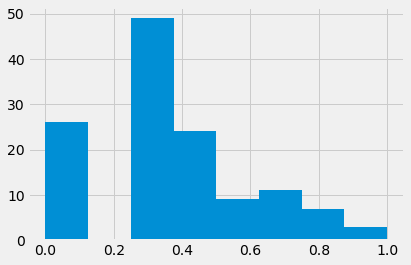

In [39]:
plt.hist(scalled,bins=8)

In [40]:
df['diameter'] = scalled[:,0]

In [41]:
df[cols_to_scale].describe()

,diameter
count,129.000000
mean,0.355482
std,0.233762
min,0.000000
25%,0.285714
50%,0.285714
75%,0.428571
max,1.000000


正規化した数量データとエンコードしてカテゴリカルデータを結合

In [42]:
new_df = pd.concat([dummies,df],axis=1)
new_df.shape

(129, 43)

目的変数yは価格、それ以外を説明変数xとして分離

In [43]:
x,y = new_df.drop('price_yen',axis=1),df['price_yen']
x.shape,y.shape

((129, 42), (129,))

学習データのサンプリング

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((90, 42), (39, 42), (90,), (39,))

In [45]:
x_train

,company_B,company_C,company_D,company_E,topping_black papper,topping_chicken,topping_meat,topping_mozzarella,topping_mushrooms,topping_onion,topping_papperoni,topping_sausage,topping_smoked beef,topping_tuna,topping_vegetables,variant_BBQ_sausage,variant_american_classic,variant_american_favorite,variant_classic,variant_crunchy,variant_double_decker,variant_double_mix,variant_double_signature,variant_extravaganza,variant_gournet_greek,variant_italian_veggie,variant_meat_eater,variant_meat_lovers,variant_neptune_tuna,variant_new_york,variant_spicy tuna,variant_spicy_tuna,variant_super_supreme,variant_thai_veggie,size_jumbo,size_large,size_medium,size_reguler,size_small,extra_sauce_yes,extra_cheese_yes,diameter
122,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.642857
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.285714
15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0.750000
16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0.571429
102,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.285714
28,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.285714
99,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.642857
59,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0.285714


# 学習モデル
様々な学習モデルをつかって学習させてみる

In [46]:
models = [LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),RandomForestRegressor(),SVR(),KNeighborsRegressor(),MLPRegressor()]

In [47]:
mean_scores = []

for model in models:
    print("Model:",model)
    cv_score = cross_val_score(model,x,y,cv=5)
    print("CV scores:",cv_score)
    mean_score = cv_score.mean()
    print("Mean Score:",mean_score)
    print('\n')
    mean_scores.append(mean_score)

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CV scores: [-5.01280584e+24 -3.40228525e+22 -6.69814992e+25  8.36070740e-01
 -2.58175341e+25]
Mean Score: -1.9569172397461323e+25


Model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
CV scores: [0.59174188 0.65289556 0.65235731 0.84976629 0.63196046]
Mean Score: 0.6757443015472093


Model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
CV scores: [0.60927958 0.6959945  0.80215388 0.89048218 0.66054521]
Mean Score: 0.7316910681152207


Model: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CV scores: [-5.08508542 -6.61681397 -5.66561235 -3.17841916 -6.97018157]
Mean Score: -5.503222493016333




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [48]:
mean_scores = np.array(mean_scores)

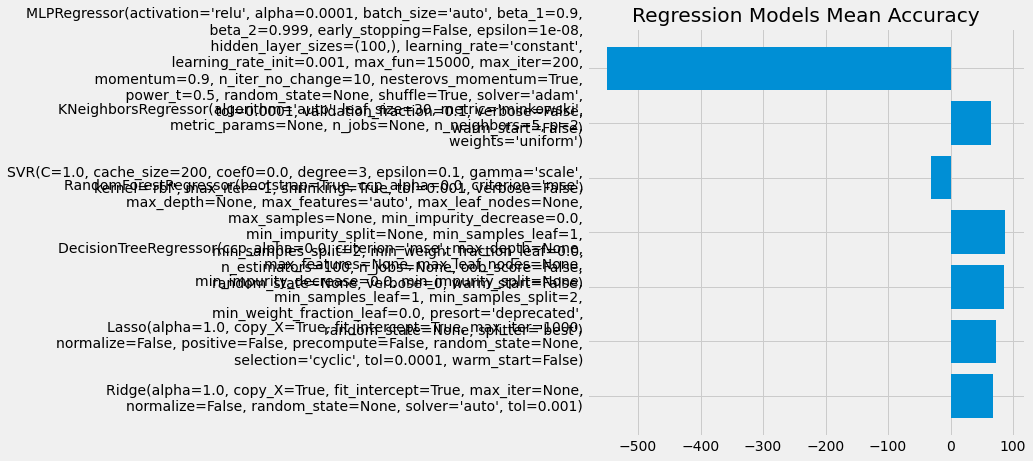

In [49]:
plt.figure(figsize=(7,7))
plt.barh(range(7),mean_scores[1:]*100)
plt.title('Regression Models Mean Accuracy')
plt.yticks(range(7),models[1:])
plt.show()

上記の結果で，ランダムフォレスト，決定木のスコア高く，ニューラルネット，SVMの成績が極めて悪い。これはカテゴリカルデータが殆どであるため，勾配がつくれていないことによる。このような場合はいったんカテゴリでクラスタリングできないかどうか，またカテゴリカルであっても順序化できる属性がないかを考える。
ただしこのケースではexstraの部分くらいしか順序化できる余地がないため，決定木ベースの方法がやはり優位になると思われる。

In [50]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train,y_train)
rf_model.score(x_test,y_test)

0.7580568496296444

In [51]:
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train,y_train)
dt_model.score(x_test,y_test)

0.7073541691380894

In [52]:
def predict(model,x):
    pred = model.predict(x)
    return pred

def actual_vs_predicted(label,y_true,y_pred,title=None):
    ap = pd.DataFrame({f'{label} Actual':y_true,f'{label} Predicted':y_pred})
    
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=ap, x=f'{label} Actual', y=f'{label} Predicted')
    plt.title(title)
    plt.show()

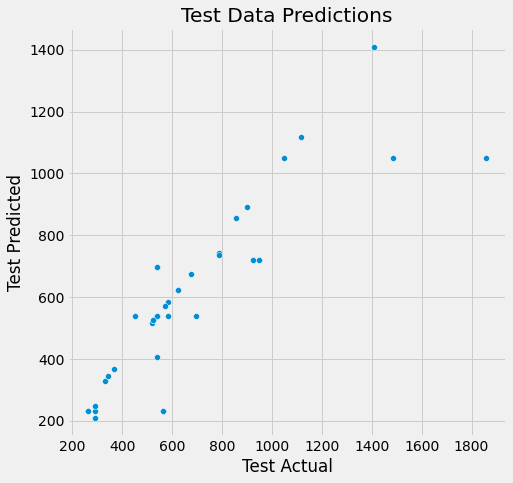

In [53]:
y_test_pred = predict(dt_model,x_test)

actual_vs_predicted('Test',y_test,y_test_pred,'Test Data Predictions')

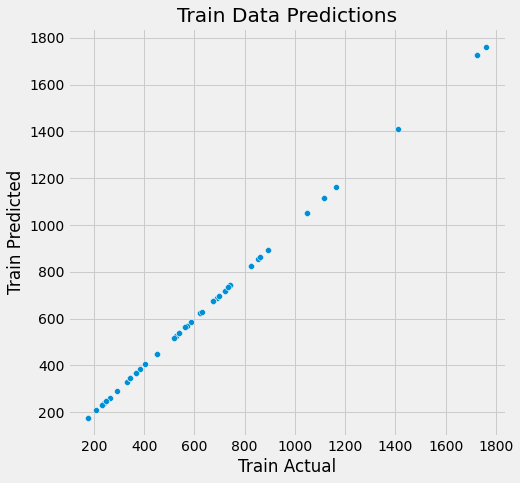

In [54]:
y_train_pred = predict(dt_model,x_train)

actual_vs_predicted('Train',y_train,y_train_pred,'Train Data Predictions')